# Advertiser Spend Analytics Project
This notebook loads your Olist datasets and begins analysis.

✅ Make sure your `data/` folder is next to this notebook.


In [1]:
# --- Setup & utilities ---
import os, sys, math, textwrap, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Project paths
PROJ = Path.cwd()  # should be .../Desktop/ms_ad_analytics_project
DATA = PROJ / "data"
OUT  = PROJ / "output"
OUT.mkdir(exist_ok=True)

print("Working directory:", PROJ)
print("Data folder exists:", DATA.exists())
print("Output folder:", OUT)


Working directory: C:\Users\78350\OneDrive\Desktop\ms_ad_analytics_project
Data folder exists: True
Output folder: C:\Users\78350\OneDrive\Desktop\ms_ad_analytics_project\output


## ✅ Load Data

In [2]:
# Load the data

def load_csv(name: str, required: bool = True, parse_dates=None):
    fp = DATA / name
    if fp.exists():
        return pd.read_csv(fp, parse_dates=parse_dates)
    if required:
        raise FileNotFoundError(f"Required file not found: {fp}")
    else:
        print(f"[Optional] File not found (skipping): {fp}")
        return None

customers   = load_csv("olist_customers_dataset.csv")
orders      = load_csv("olist_orders_dataset.csv", parse_dates=[
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
])
order_items = load_csv("olist_order_items_dataset.csv")
products    = load_csv("olist_products_dataset.csv")

# Optional files
payments    = load_csv("olist_order_payments_dataset.csv", required=False)
reviews     = load_csv("olist_order_reviews_dataset.csv", required=False)
sellers     = load_csv("olist_sellers_dataset.csv", required=False)
geo         = load_csv("olist_geolocation_dataset.csv", required=False)
cat_map     = load_csv("product_category_name_translation.csv", required=False)

print("Loaded tables:", customers.shape, orders.shape, order_items.shape, products.shape)


Loaded tables: (99441, 5) (99441, 8) (112650, 7) (32951, 9)


In [5]:
# --- Clean and filter orders ---

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

# Convert date columns to datetime
for c in date_cols:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors="coerce")

# Keep only delivered / shipped / invoiced / approved
valid_status = orders["order_status"].isin([
    "delivered", "shipped", "invoiced", "approved"
])

orders_clean = orders.loc[valid_status].copy()

# Add simple date fields
orders_clean["order_date"] = orders_clean["order_purchase_timestamp"].dt.date
orders_clean["order_month"] = (
    orders_clean["order_purchase_timestamp"]
        .dt.to_period("M")
        .astype(str)
)

# Show checks
print("Orders before:", len(orders), "| after filter:", len(orders_clean))
orders_clean["order_status"].value_counts().head()


Orders before: 99441 | after filter: 97901


order_status
delivered    96478
shipped       1107
invoiced       314
approved         2
Name: count, dtype: int64

In [7]:
# Merge items ↔ order headers
items = order_items.merge(
    orders_clean[["order_id","customer_id","order_purchase_timestamp","order_status"]],
    on="order_id",
    how="inner"
)

# Attach product category (English if mapping is present)
items = items.merge(products[["product_id","product_category_name"]], on="product_id", how="left")

if cat_map is not None and "product_category_name_english" in cat_map.columns:
    items = items.merge(cat_map, on="product_category_name", how="left")
    items["category"] = items["product_category_name_english"].fillna(items["product_category_name"])
else:
    items["category"] = items["product_category_name"]

# Key derived fields
items["order_date"]  = items["order_purchase_timestamp"].dt.date
items["order_month"] = items["order_purchase_timestamp"].dt.to_period("M").astype(str)

# Total revenue per line
items["line_revenue"] = items["price"] + items.get("freight_value", 0)

# Rename seller → advertiser
fact = items.rename(columns={"seller_id":"advertiser_id"}).copy()

# Aggregations
order_level = (
    fact.groupby(["order_id"], as_index=False)
        .agg(
            advertiser_count=("advertiser_id","nunique"),
            order_revenue=("line_revenue","sum"),
            first_ts=("order_purchase_timestamp","min")
        )
)

daily_adv = (
    fact.groupby(["advertiser_id","order_date"], as_index=False)
        .agg(
            orders=("order_id","nunique"),
            lines=("order_item_id","count"),
            revenue=("line_revenue","sum"),
            customers=("customer_id","nunique")
        )
)
daily_adv["order_date"] = pd.to_datetime(daily_adv["order_date"])

monthly_adv = (
    fact.groupby(["advertiser_id","order_month"], as_index=False)
        .agg(
            orders=("order_id","nunique"),
            lines=("order_item_id","count"),
            revenue=("line_revenue","sum"),
            customers=("customer_id","nunique")
        )
)

daily_adv.head(), monthly_adv.head()


(                      advertiser_id order_date  orders  lines  revenue  customers
 0  0015a82c2db000af6aaaf3ae2ecb0532 2017-09-26       1      1   916.02          1
 1  0015a82c2db000af6aaaf3ae2ecb0532 2017-10-12       1      1   916.02          1
 2  0015a82c2db000af6aaaf3ae2ecb0532 2017-10-18       1      1   916.02          1
 3  001cca7ae9ae17fb1caed9dfb1094831 2017-02-04       1      1   121.05          1
 4  001cca7ae9ae17fb1caed9dfb1094831 2017-02-18       1      5   573.85          1,
                       advertiser_id order_month  orders  lines  revenue  customers
 0  0015a82c2db000af6aaaf3ae2ecb0532     2017-09       1      1   916.02          1
 1  0015a82c2db000af6aaaf3ae2ecb0532     2017-10       2      2  1832.04          2
 2  001cca7ae9ae17fb1caed9dfb1094831     2017-02       5     11  1295.40          5
 3  001cca7ae9ae17fb1caed9dfb1094831     2017-03      11     17  2124.00         11
 4  001cca7ae9ae17fb1caed9dfb1094831     2017-04      14     16  2243.22         

In [8]:
# --- CORE KPIs ---

# Total revenue + AOV
total_revenue = order_level["order_revenue"].sum()
total_orders  = order_level["order_id"].nunique()
aov           = order_level["order_revenue"].mean()

# Customer-level metrics
cust_orders = (
    orders_clean.merge(
        order_level[["order_id", "order_revenue"]],
        on="order_id",
        how="left"
    )
    .groupby("customer_id", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        revenue=("order_revenue", "sum"),
        first_purchase=("order_purchase_timestamp", "min"),
        last_purchase=("order_purchase_timestamp", "max"),
    )
)

repeat_rate = (cust_orders["orders"] > 1).mean()
avg_orders_per_customer = cust_orders["orders"].mean()

print("===== CORE KPIs =====")
print(f"Total Revenue: ${total_revenue:,.0f}")
print(f"Total Orders: {total_orders:,}")
print(f"AOV (Avg Order Value): ${aov:,.2f}")
print(f"Repeat Purchase Rate: {repeat_rate:.1%}")
print(f"Average Orders per Customer: {avg_orders_per_customer:.2f}")


===== CORE KPIs =====
Total Revenue: $15,666,133
Total Orders: 97,898
AOV (Avg Order Value): $160.03
Repeat Purchase Rate: 0.0%
Average Orders per Customer: 1.00


In [10]:
# --- Advertiser (Seller) Summary ---

adv_summary = (
    fact
    .groupby("advertiser_id", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        lines=("order_item_id", "count"),
        revenue=("line_revenue", "sum"),
        unique_customers=("customer_id", "nunique"),
        first_order=("order_purchase_timestamp", "min"),
        last_order=("order_purchase_timestamp", "max")
    )
    .assign(
        aov=lambda d: d["revenue"] / d["orders"].replace(0, np.nan),
        tenure_days=lambda d: (d["last_order"] - d["first_order"]).dt.days.clip(lower=0)
    )
    .sort_values("revenue", ascending=False)
)

adv_summary.head(10)


,advertiser_id,orders,lines,revenue,unique_customers,first_order,last_order,aov,tenure_days
836,4869f7a5dfa277a7dca6462dcf3b52b2,1131,1155,249393.44,1131,2017-03-14 10:20:54,2018-08-24 19:42:51,220.507020,528
1487,7c67e1448b00f6e969d365cea6b010ab,982,1364,239536.44,982,2017-01-26 22:44:11,2018-08-07 18:58:53,243.927128,557
985,53243585a1d6dc2643021fd1853d8905,357,409,235581.79,357,2017-08-28 18:29:21,2018-08-21 09:52:32,659.892969,357
860,4a3ca9315b744ce9f8e9374361493884,1804,1985,235359.30,1804,2017-01-08 09:35:14,2018-08-27 10:46:11,130.465244,596
2920,fa1c13f2614d7b5c4749cbc52fecda94,582,583,202533.47,582,2017-01-07 20:45:31,2018-08-29 09:48:09,347.995653,598
2556,da8622b14eb17ae2831f4ac5b9dab84a,1314,1551,185192.32,1314,2017-02-05 21:46:05,2018-08-28 21:56:30,140.937839,569
1511,7e93a43ef30c4f03f38b393420bc753a,325,328,176421.15,325,2016-10-08 01:28:14,2018-07-13 21:30:54,542.834308,643
189,1025f0e2d44d7041d6cf58b6550e0bfa,915,1428,172860.69,915,2017-07-09 11:15:16,2018-08-26 09:22:44,188.918787,412
1457,7a67c85e85bb2ce8582c35f2203ad736,1159,1170,162607.24,1159,2017-01-27 12:15:07,2018-08-21 01:30:48,140.299603,570
1767,955fee9216a65b617aa5c0531780ce60,1286,1498,160582.90,1286,2017-07-24 11:33:53,2018-08-28 20:49:17,124.870062,400


In [12]:
# --- COHORT RETENTION ANALYSIS ---

# 1) Identify each customer's first purchase month
first_purchase = (
    orders_clean
    .groupby("customer_id", as_index=False)["order_purchase_timestamp"]
    .min()
    .rename(columns={"order_purchase_timestamp": "first_ts"})
)

first_purchase["acq_month"] = first_purchase["first_ts"].dt.to_period("M").astype(str)

# 2) Attach acquisition month to every order
orders_with_acq = orders_clean.merge(first_purchase, on="customer_id", how="left")
orders_with_acq["order_month"] = orders_with_acq["order_purchase_timestamp"].dt.to_period("M").astype(str)

# 3) Define cohort index (months since acquisition)
def month_diff(acq, current):
    ay, am = map(int, acq.split("-"))
    cy, cm = map(int, current.split("-"))
    return (cy - ay)*12 + (cm - am)

orders_with_acq["cohort_index"] = [
    month_diff(acq, om)
    for acq, om in zip(orders_with_acq["acq_month"], orders_with_acq["order_month"])
]

# 4) Count active customers per cohort per period
cohort_counts = (
    orders_with_acq
    .groupby(["acq_month", "cohort_index"])["customer_id"]
    .nunique()
    .reset_index(name="active_customers")
)

# 5) Cohort sizes (size of each acquisition group)
cohort_sizes = cohort_counts[cohort_counts["cohort_index"] == 0][["acq_month", "active_customers"]]
cohort_sizes = cohort_sizes.rename(columns={"active_customers": "cohort_size"})

# 6) Merge to compute retention
cohort_retention = cohort_counts.merge(cohort_sizes, on="acq_month", how="left")
cohort_retention["retention"] = cohort_retention["active_customers"] / cohort_retention["cohort_size"]

# 7) Pivot to table format (rows = cohorts, cols = months since acquisition)
cohort_pivot = cohort_retention.pivot(
    index="acq_month", 
    columns="cohort_index", 
    values="retention"
).fillna(0)

cohort_pivot.head(10)


cohort_index,0
acq_month,
2016-09,1.0
2016-10,1.0
2016-12,1.0
2017-01,1.0
2017-02,1.0
2017-03,1.0
2017-04,1.0
2017-05,1.0
2017-06,1.0


In [13]:
# --- RFM SEGMENTATION ---

# 1) Build customer-level dataset with revenue attached
cust_rev = (
    orders_clean
    .merge(order_level[["order_id", "order_revenue"]], on="order_id", how="left")
)

# 2) Compute recency, frequency, monetary
rfm = (
    cust_rev
    .groupby("customer_id", as_index=False)
    .agg(
        last_purchase=("order_purchase_timestamp", "max"),
        frequency=("order_id", "nunique"),
        monetary=("order_revenue", "sum")
    )
)

# Today's reference point (1 day after latest order)
today = orders_clean["order_purchase_timestamp"].max().normalize() + pd.Timedelta(days=1)

# Recency in days
rfm["recency_days"] = (today - rfm["last_purchase"]).dt.days

# 3) Score R, F, M into quintiles (1 = low, 5 = best)
rfm["R"] = pd.qcut(-rfm["recency_days"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"),       5, labels=[1,2,3,4,5]).astype(int)
rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"),        5, labels=[1,2,3,4,5]).astype(int)

# Combined RFM score like 543, 221, 555, etc.
rfm["RFM_Score"] = rfm["R"]*100 + rfm["F"]*10 + rfm["M"]

rfm.head(10)


,customer_id,last_purchase,frequency,monetary,recency_days,R,F,M,RFM_Score
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,1,114.74,293,2,1,3,213
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,1,67.41,414,1,1,2,112
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,1,195.42,552,1,1,4,114
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,1,179.35,383,2,1,4,214
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,1,107.01,154,4,1,3,413
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,1,71.80,509,1,1,2,112
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,1,49.40,185,4,1,1,411
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,1,166.59,259,3,1,4,314
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,1,85.23,351,2,1,2,212
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1,1255.71,23,5,1,5,515


In [14]:
# --- COHORT RETENTION ANALYSIS ---

# 1) Identify each customer's first purchase month
first_purchase = (
    orders_clean
    .groupby("customer_id", as_index=False)["order_purchase_timestamp"]
    .min()
    .rename(columns={"order_purchase_timestamp": "first_ts"})
)

first_purchase["acq_month"] = first_purchase["first_ts"].dt.to_period("M").astype(str)

# 2) Attach acquisition month to every order
orders_with_acq = orders_clean.merge(first_purchase, on="customer_id", how="left")
orders_with_acq["order_month"] = orders_with_acq["order_purchase_timestamp"].dt.to_period("M").astype(str)

# 3) Define cohort index (months since acquisition)
def month_diff(acq, current):
    ay, am = map(int, acq.split("-"))
    cy, cm = map(int, current.split("-"))
    return (cy - ay)*12 + (cm - am)

orders_with_acq["cohort_index"] = [
    month_diff(acq, om)
    for acq, om in zip(orders_with_acq["acq_month"], orders_with_acq["order_month"])
]

# 4) Count active customers per cohort per period
cohort_counts = (
    orders_with_acq
    .groupby(["acq_month", "cohort_index"])["customer_id"]
    .nunique()
    .reset_index(name="active_customers")
)

# 5) Cohort sizes (size of each acquisition group)
cohort_sizes = cohort_counts[cohort_counts["cohort_index"] == 0][["acq_month", "active_customers"]]
cohort_sizes = cohort_sizes.rename(columns={"active_customers": "cohort_size"})

# 6) Merge to compute retention
cohort_retention = cohort_counts.merge(cohort_sizes, on="acq_month", how="left")
cohort_retention["retention"] = cohort_retention["active_customers"] / cohort_retention["cohort_size"]

# 7) Pivot to table format (rows = cohorts, cols = months since acquisition)
cohort_pivot = cohort_retention.pivot(
    index="acq_month", 
    columns="cohort_index", 
    values="retention"
).fillna(0)

cohort_pivot.head(10)


cohort_index,0
acq_month,
2016-09,1.0
2016-10,1.0
2016-12,1.0
2017-01,1.0
2017-02,1.0
2017-03,1.0
2017-04,1.0
2017-05,1.0
2017-06,1.0


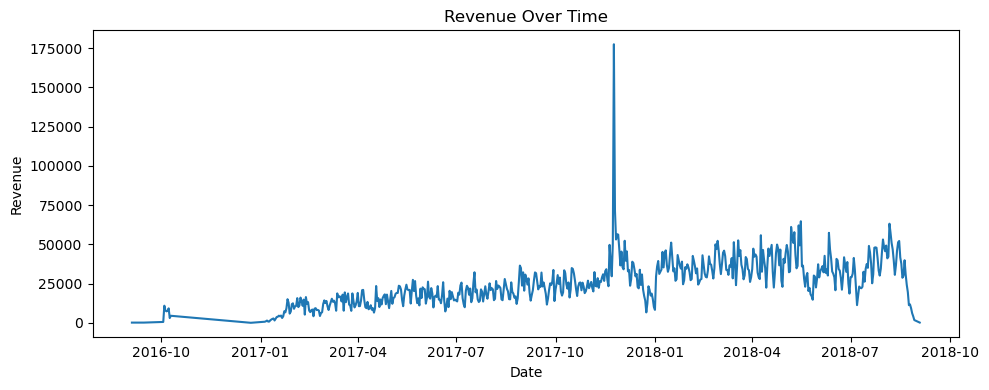

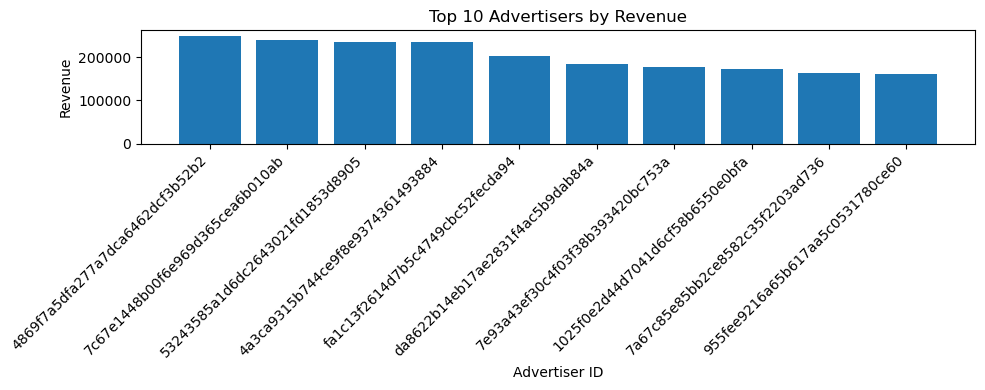

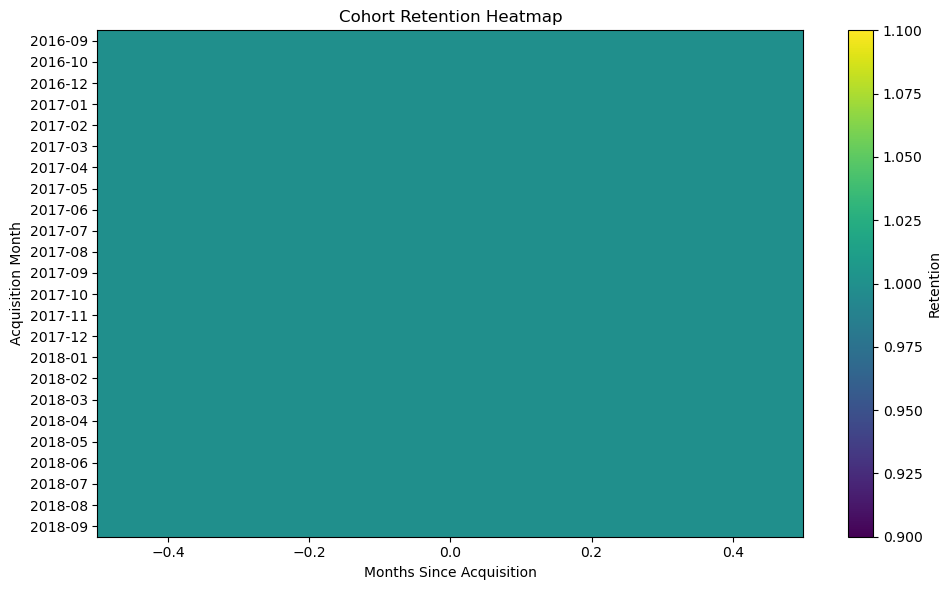

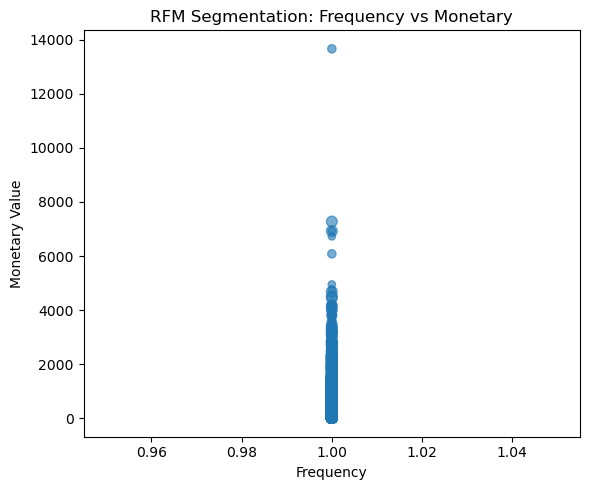

In [15]:
# --- VISUALIZATIONS ---

import matplotlib.pyplot as plt
plt.style.use("default")

# 1) Revenue over time (daily)
daily_rev = (
    fact.groupby("order_date", as_index=False)
        .agg(revenue=("line_revenue", "sum"))
)
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily_rev["order_date"]), daily_rev["revenue"])
plt.title("Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# 2) Top 10 Advertisers by revenue
top_adv = adv_summary.head(10)

plt.figure(figsize=(10,4))
plt.bar(top_adv["advertiser_id"].astype(str), top_adv["revenue"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Advertisers by Revenue")
plt.xlabel("Advertiser ID")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# 3) Cohort retention heatmap
plt.figure(figsize=(10,6))
plt.imshow(cohort_pivot.values, aspect="auto", cmap="viridis")
plt.colorbar(label="Retention")
plt.title("Cohort Retention Heatmap")
plt.xlabel("Months Since Acquisition")
plt.ylabel("Acquisition Month")
plt.yticks(
    ticks=range(len(cohort_pivot.index)),
    labels=cohort_pivot.index
)
plt.tight_layout()
plt.show()

# 4) RFM scatter: Frequency vs Monetary, sized by Recency
plt.figure(figsize=(6,5))
plt.scatter(
    rfm["frequency"],
    rfm["monetary"],
    s=20 + (rfm["R"] * 8),  # bigger bubble = more recent
    alpha=0.6
)
plt.title("RFM Segmentation: Frequency vs Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.tight_layout()
plt.show()


In [17]:
# --- EXPORT CLEAN TABLES FOR POWER BI / PORTFOLIO ---

adv_summary.to_csv(OUT / "advertiser_summary.csv", index=False)
daily_adv.to_csv(OUT / "advertiser_daily.csv", index=False)
monthly_adv.to_csv(OUT / "advertiser_monthly.csv", index=False)
rfm.to_csv(OUT / "customer_rfm.csv", index=False)
cohort_pivot.to_csv(OUT / "cohort_retention_pivot.csv")

print("✅ Exported the following files:")
for f in OUT.iterdir():
    print(" -", f.name)


✅ Exported the following files:
 - advertiser_daily.csv
 - advertiser_monthly.csv
 - advertiser_summary.csv
 - cohort_retention_pivot.csv
 - customer_rfm.csv
